# Hourly time series forecasting using XGBoost

## Import dependencies

In [1]:
# Data loading, processing and analysis
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Machine learning
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

## About the dataset

### PJM Hourly Energy Consumption Data

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

## Load the data

In [2]:
df = pd.read_csv('AEP_hourly.zip')
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [3]:
df.shape

(121273, 2)

In [4]:
df.dtypes

Datetime     object
AEP_MW      float64
dtype: object

### Converting the Datetime column to proper data type

In [5]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.sort_values('Datetime', ascending=True, inplace=True) # Sorting chronologically

## Plot the data

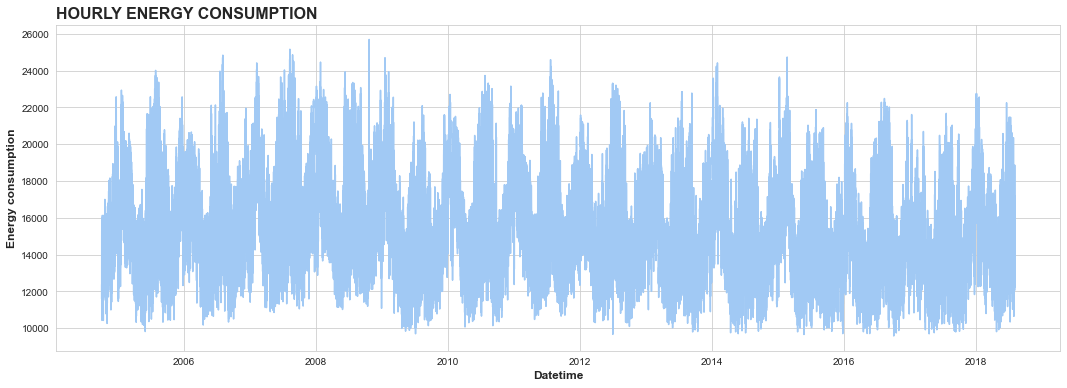

In [6]:
fig, ax = plt.subplots(figsize=(18, 6))
plot = sns.lineplot(x='Datetime',
                    y='AEP_MW',
                    data=df, 
                    ax=ax)
plot.set_ylabel('Energy consumption', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plot.set_xlabel('Datetime', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plot.set_title('Hourly energy consumption'.upper(), fontdict={'fontsize': 16, 'fontweight': 'bold'}, loc='left')
plt.show()

## Train/test split

We're spliting the data to simulate a real-world problem in which we don't know the future. So the training set will be the historical data up to the end of 2014 and the test set will be the remaining "future" data which may also be called as validation set.

In [7]:
split_date = '2015-01-01'
train_set = df.loc[df['Datetime'] < split_date].copy(deep=True) # Good practice to copy the original data instead of editing it inplace
test_set = df.loc[df['Datetime'] >= split_date].copy(deep=True)

### Plot the data

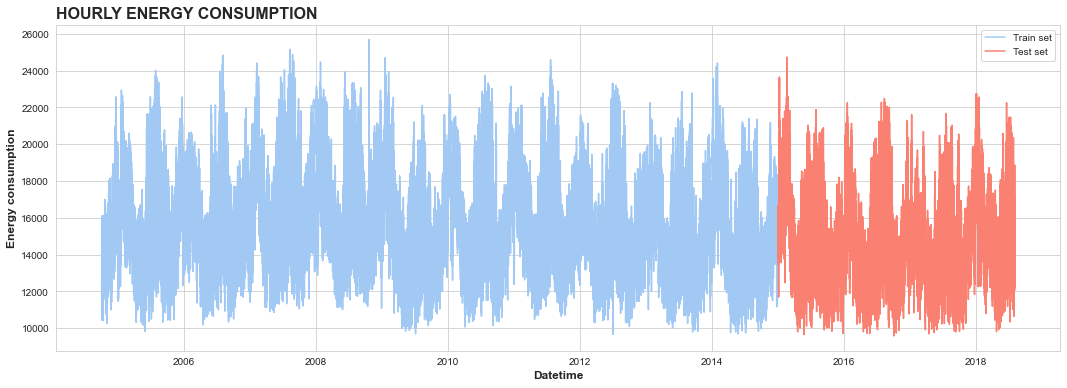

In [8]:
fig, ax = plt.subplots(figsize=(18, 6))
train_plot = sns.lineplot(x='Datetime', y='AEP_MW', data=train_set, label='Train set', ax=ax)
test_plot = sns.lineplot(x='Datetime', y='AEP_MW', data=test_set, label='Test set', color='salmon', ax=ax)
ax.set_ylabel('Energy consumption', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_xlabel('Datetime', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Hourly energy consumption'.upper(), fontdict={'fontsize': 16, 'fontweight': 'bold'}, loc='left')
plt.show()

## Feature engineering

Adding time series features

In [9]:
def add_features(df, return_names=False):
    """
    Creates time series features using the Datetime column and splits the data into X and y.
    
    """   
    df = df.copy(deep=True)
    df['year'] = df['Datetime'].dt.year
    df['quarter'] = df['Datetime'].dt.quarter
    df['month'] = df['Datetime'].dt.month
    df['week_of_year'] = df['Datetime'].dt.isocalendar().week
    df['day_of_year'] = df['Datetime'].dt.dayofyear
    df['day'] = df['Datetime'].dt.day
    df['day_of_week'] = df['Datetime'].dt.dayofweek
    df['hour'] = df['Datetime'].dt.hour
    
    cols = ['year', 'quarter', 'month', 'week_of_year', 'day_of_year', 'day', 'day_of_week', 'hour']
    X, y = (df.drop(columns=['Datetime', 'AEP_MW']).values, # X
            df['AEP_MW'].values,) # y
    if return_names:
        return X, y, cols
    return X, y

In [10]:
X_train, y_train, feature_names = add_features(train_set, return_names=True)
X_test, y_test = add_features(test_set)

## Creating our model

We're using the XGBoost model

In [11]:
evaluation_set = [(X_train, y_train), (X_test, y_test)]

reg = xgb.XGBRegressor(n_estimators=1000,
                       max_depth=10,
                       learning_rate=0.01,
                       random_state=123,)

reg.fit(X_train, y_train,
        eval_set=evaluation_set,
        early_stopping_rounds=50,
        verbose=50)

[0]	validation_0-rmse:15792.28018	validation_1-rmse:14864.50177


C:\Users\breno.i.santos\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-rmse:9618.60116	validation_1-rmse:8875.09748
[100]	validation_0-rmse:5902.04733	validation_1-rmse:5322.34533
[150]	validation_0-rmse:3676.18519	validation_1-rmse:3290.32238
[200]	validation_0-rmse:2361.75736	validation_1-rmse:2240.73192
[250]	validation_0-rmse:1607.02938	validation_1-rmse:1796.45742
[300]	validation_0-rmse:1193.11573	validation_1-rmse:1665.87371
[350]	validation_0-rmse:973.67753	validation_1-rmse:1661.18453
[377]	validation_0-rmse:903.27772	validation_1-rmse:1675.36825


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, ...)

### Model evaluation

In [12]:
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred)

2735418.2184376493

## Feature importances

In [13]:
importance_df = pd.DataFrame(data=reg.feature_importances_, 
                             index=feature_names,
                             columns=['feature_importance']).sort_values('feature_importance')
importance_df

,feature_importance
day,0.020778
year,0.035846
month,0.036885
quarter,0.045678
week_of_year,0.109791
day_of_year,0.121189
day_of_week,0.145887
hour,0.483945


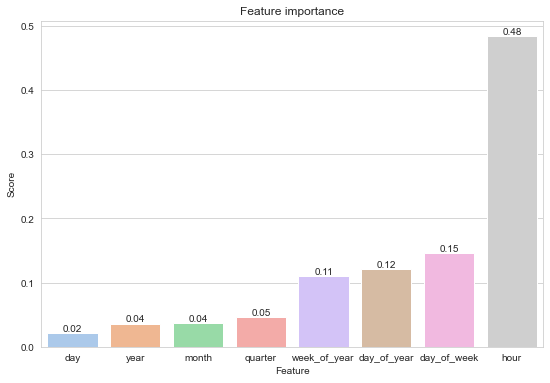

In [14]:
fig, ax = plt.subplots(figsize=(9, 6))
plot_data = pd.DataFrame()
bar = sns.barplot(x='index',
                  y='feature_importance',
                  data=importance_df.reset_index(),
                  ax=ax)

bar.set_title('Feature importance')
bar.set_xlabel('Feature')
bar.set_ylabel('Score')
bar.bar_label(ax.containers[0], fmt='%.2f')
plt.show()

- Looks like the day of the month can be droped.
- The year variable doesn't seem to impact to the model aswell as it should be expected since the main objective is to predict hourly energy consumption with seasonal variations.
- The most important variable is the hour as the energy consumption tends to increase during the night.
- It's expected a seasonal variation so the low performance of the quarter variable may be compensated creating a season variable to account for the increase of energy consumption on winter and summer because of heating and air conditioning respectively.

## Forecasting

Adding a predictions column to our data.

In [15]:
df_pred = test_set.copy(deep=True)
df_pred['AEP_MW_pred'] = y_pred
df_pred.tail()

,Datetime,AEP_MW,AEP_MW_pred
116157,2018-08-02 20:00:00,17673.0,16730.480469
116158,2018-08-02 21:00:00,17303.0,16520.240234
116159,2018-08-02 22:00:00,17001.0,16260.801758
116160,2018-08-02 23:00:00,15964.0,15237.198242
116161,2018-08-03 00:00:00,14809.0,13828.649414


In [16]:
df = df.join(df_pred['AEP_MW_pred'])

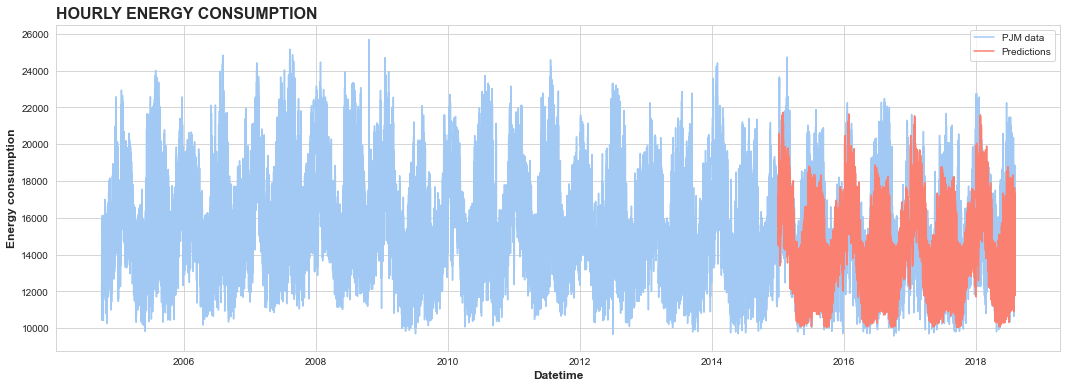

In [17]:
fig, ax = plt.subplots(figsize=(18, 6))
plot = sns.lineplot(x='Datetime', y='AEP_MW', data=df, label='PJM data', ax=ax)
pred_plot = sns.lineplot(x='Datetime', y='AEP_MW_pred', data=df, color='salmon', label='Predictions', ax=ax)
plot.set_ylabel('Energy consumption', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plot.set_xlabel('Datetime', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plot.set_title('Hourly energy consumption'.upper(), fontdict={'fontsize': 16, 'fontweight': 'bold'}, loc='left')
plt.show()

The model seems to be struggling to identify peaks of energy consumption.

### First predicted month

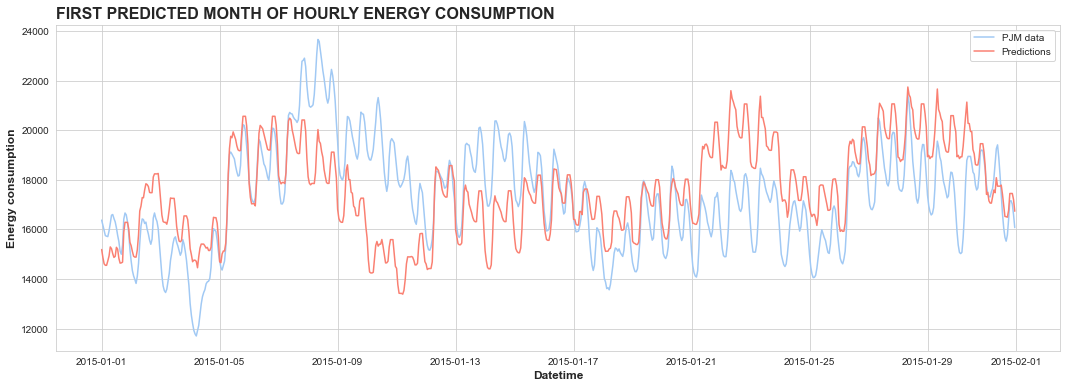

In [18]:
fig, ax = plt.subplots(figsize=(18, 6))
mask = df['Datetime'].dt.to_period('M') == '2015-01'
plot = sns.lineplot(x='Datetime', y='AEP_MW', data=df[mask], label='PJM data', ax=ax)
pred_plot = sns.lineplot(x='Datetime', y='AEP_MW_pred', data=df[mask], color='salmon', label='Predictions', ax=ax)
plot.set_ylabel('Energy consumption', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plot.set_xlabel('Datetime', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plot.set_title('First predicted month of hourly energy consumption'.upper(), fontdict={'fontsize': 16, 'fontweight': 'bold'}, loc='left')
plt.show()

#### First predicted month error

In [19]:
mean_squared_error(y_true=df.loc[mask, 'AEP_MW'].values,
                   y_pred=df.loc[mask, 'AEP_MW_pred'].values)

3964562.84543207

## Best and worst predictions

Negative error values should be bad as I'm predicting there's going to be a lower energy consumption than the actual consumption.

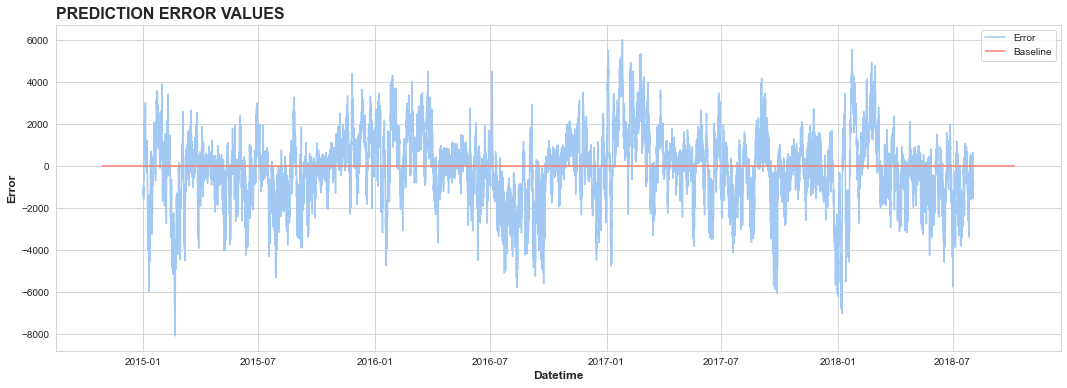

In [20]:
df['error'] = df['AEP_MW_pred'] - df['AEP_MW']

fig, ax = plt.subplots(figsize=(18, 6))
mask = df['AEP_MW_pred'].notna() # Fetching only predicted data
plot = sns.lineplot(x='Datetime', y='error', data=df[mask], label='Error', ax=ax)
plot.set_ylabel('Error', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plot.set_xlabel('Datetime', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plot.set_title('Prediction error values'.upper(), fontdict={'fontsize': 16, 'fontweight': 'bold'}, loc='left')
xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='salmon', label='Baseline')
ax.legend()
plt.show()

### Daily predictions

In [21]:
df['error'] = df['AEP_MW_pred'] - df['AEP_MW']
df['abs_error'] = abs(df['error'])

df['year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
df['day_name'] = df['Datetime'].dt.day_name()

# Checking for US-Holidays
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start=df['Datetime'].min(), end=df['Datetime'].max())
df['holiday'] = df['Datetime'].isin(holidays)

error_df = df.groupby([df['Datetime'].dt.date, 'day_name', 'holiday']).agg(total_predicted_consumption=('AEP_MW_pred', 'sum'),
                                                                           total_actual_consumption=('AEP_MW', 'sum'),
                                                                           total_error=('error', 'sum'),
                                                                           abs_error=('abs_error', 'sum'),
                                                                           MAE=('abs_error', 'mean'))
error_df = error_df[error_df['total_predicted_consumption'] > 0].sort_values('MAE', ascending=False).head(10) # Fetching only predcted data
error_df

,,,total_predicted_consumption,total_actual_consumption,total_error,abs_error,MAE
Datetime,day_name,holiday,,,,,
2015-02-19,Thursday,False,384509.656250,533988.0,-149478.339844,149478.339844,6228.264160
2015-02-20,Friday,False,384675.406250,529129.0,-144453.604492,144453.604492,6018.900187
2017-01-25,Wednesday,False,480722.250000,356699.0,124023.265625,124023.265625,5167.636068
2018-01-06,Saturday,False,380142.937500,500348.0,-120205.068359,120205.068359,5008.544515
2018-01-01,Monday,True,13685.053711,18687.0,-5001.946289,5001.946289,5001.946289
2017-12-31,Sunday,False,325360.062500,441162.0,-115801.932617,115801.932617,4825.080526
2017-12-28,Thursday,False,349844.218750,465511.0,-115666.794922,115666.794922,4819.449788
2018-01-23,Tuesday,False,473689.593750,359953.0,113736.591797,113736.591797,4739.024658
2018-01-01,Monday,False,342035.812500,449637.0,-107601.186523,107601.186523,4678.312458


### Day of week

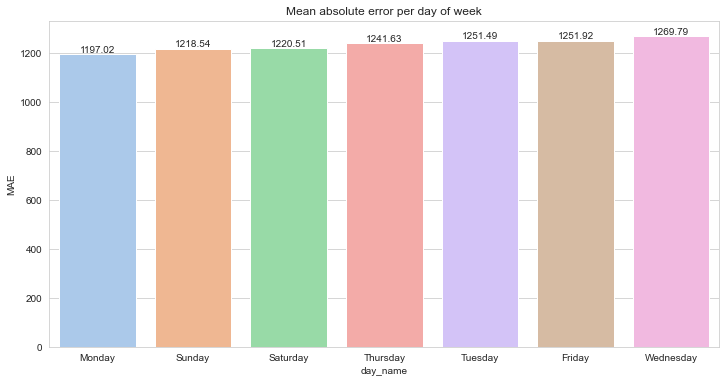

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_data = df.groupby('day_name', as_index=False).agg(MAE=('abs_error', 'mean')).sort_values(by='MAE', ascending=True)
bar = sns.barplot(x='day_name', y='MAE', data=plot_data, ax=ax)

bar.set_title('Mean absolute error per day of week')
bar.bar_label(ax.containers[0], fmt='%g')
plt.show()

### Holidays

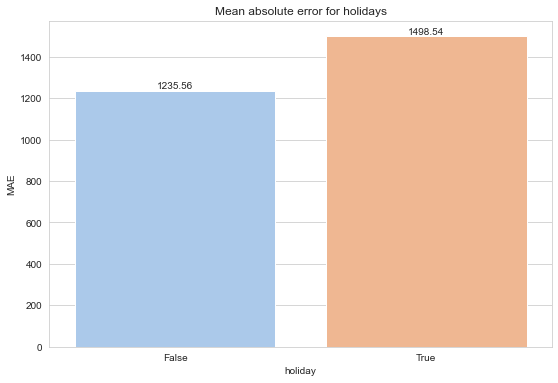

In [23]:
fig, ax = plt.subplots(figsize=(9, 6))
plot_data = df.groupby('holiday', as_index=False).agg(MAE=('abs_error', 'mean')).sort_values(by='MAE', ascending=True)
bar = sns.barplot(x='holiday', y='MAE', data=plot_data, ax=ax)

bar.set_title('Mean absolute error for holidays')
bar.bar_label(ax.containers[0], fmt='%g')
plt.show()

Looks like the model could use a holiday indicator column since on actual holiday days the model performed worse.

### Seasons

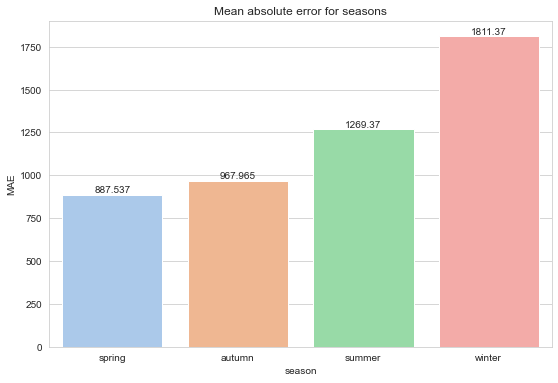

In [24]:
seasons = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'autumn'}
df['season'] = (df['month']%12 // 3 + 1).map(seasons)

fig, ax = plt.subplots(figsize=(9, 6))
plot_data = df.groupby('season', as_index=False).agg(MAE=('abs_error', 'mean')).sort_values(by='MAE', ascending=True)
bar = sns.barplot(x='season', y='MAE', data=plot_data, ax=ax)

bar.set_title('Mean absolute error for seasons')
bar.bar_label(ax.containers[0], fmt='%g')
plt.show()

Looks like the model could use a season indicator as well as we've seen when analysing the feature importances and realising that the quarter variable isn't performing well.

## Next steps

- Remove the "day" (day of month) variable - it's not as important.
- Add the holiday indicator variable.
- Add the season variable.
- Search for weather data source - Temperature across the days since it'd help identifying colder and warmer days.
- Try windowing - Use the previous 6 or 12 hours energy consumption to predict the next step.